In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from DART.DART import DART

In [2]:
# main parameters
gray_lvls = [80, 200]
dart = DART(gray_lvls)

Original phantom


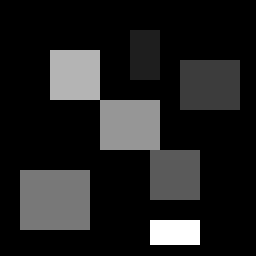

In [3]:
# create a simple phantom
img = np.full(fill_value=0,shape=(256,256))
img[30:80, 130: 160] = 30
img[60:110, 180:240] = 60
img[150:200, 150:200] = 90
img[170:230, 20:90] = 120
img[100:150, 100:160] = 150
img[50:100, 50:100] = 180
img[220:245,150:200] = 255
img = img.astype(np.uint8)
print("Original phantom")
Image.fromarray(img)

<br/>
<h4>Segmentation step</h4>

Unique intensities values in segmented image: [ 80 200]
Segmented image:


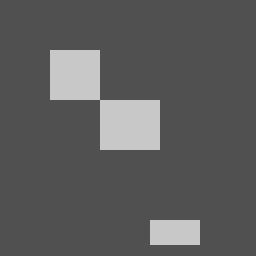

In [4]:
# Segmentation step
segmented_img = dart.segment(img)
print(f"Unique intensities values in segmented image: {np.unique(segmented_img)}")
print("Segmented image:")
Image.fromarray(segmented_img)

<br/>
<h4>Boundary pixels</h4>

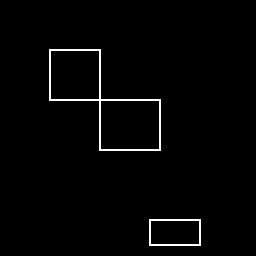

In [5]:
boundary_pixels = dart.boundary_pixels(img)
Image.fromarray(boundary_pixels*255)

<br/>
<h4>Non boundary free pixels</h4>

free pixels mask shape: (256, 256), total free pixels: 644


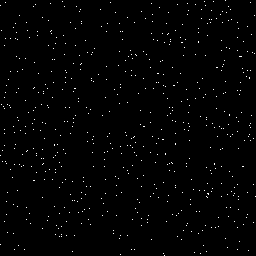

In [6]:
non_boundary_pixels = dart.non_boundary_free_pixels(boundary_pixels,0.99)
print(f"free pixels mask shape: {non_boundary_pixels.shape}, total free pixels: {non_boundary_pixels.sum()}")
Image.fromarray(non_boundary_pixels*255)

<br/>
<h4>Free pixels</h4>

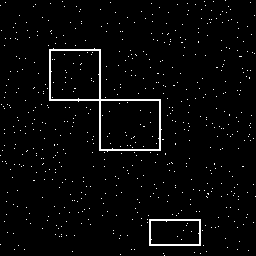

In [7]:
free_pixels = boundary_pixels + non_boundary_pixels
Image.fromarray(free_pixels*255)